In [1]:
from __future__ import print_function

import cobra
import cobra.test
import mackinac
import numpy as np
import csv
import glob
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
mackinac.get_token('tjmoutinho')

In [2]:
fasta_file_paths = glob.glob('../nt_fastas/*.faa')
# fasta_genome_ids = [x.replace("../nt_fastas/","").replace(".faa","") for x in fasta_file_paths]

In [3]:
#!/usr/bin/python2.7
'''USAGE: contigStats.py seqFile
This script calculates various statistics about the provided fasta or fastq file.
'''
import sys
import math

# This function reads in fasta file, appends the length of each sequence to a list, and counts all Gs & Cs.
        # It returns a sorted list of sequence lengths with the G+C % as the last element.
def read_lengths(fasta):

        len_lst = []
        gc_cnt = 0
        n_cnt = 0
        all_cnt = 0
        seq = ''
        firstLine = 'placeholder'
        while firstLine[0] != '>' or firstLine == '\n':
                firstLine = fasta.readline()

        for line in fasta:
                if line[0] == '>': 
                        gc_cnt += seq.count('G')
                        gc_cnt += seq.count('C')
                        n_cnt += seq.count('N')
                        all_cnt += len(seq)
                        len_lst.append(len(seq))
                        seq = ''
                else:
                        seq += line.strip().upper()

        gc_cnt += seq.count('G')
        gc_cnt += seq.count('C')
        n_cnt += seq.count('N')
        all_cnt += len(seq)
        len_lst.append(len(seq))

        gc_prcnt = round((float(gc_cnt) / float(all_cnt)) * 100.0, 2)
        len_lst.sort()

        return(len_lst, gc_prcnt, n_cnt)


# Function t0 calculate satdard deviation for a list of numbers
def standDev(values):
        x_mean = sum(values) / len(values)
        sd_list = []
        for x in values:
                y = (x - x_mean) ** 2
                sd_list.append(y)
        y_mean = sum(sd_list) / len(sd_list)   
        sd = math.sqrt(y_mean)
        return(sd)


# This function calculates and returns all the printed statistics.
def calc_stats(lengths):

        shortest = lengths[0]
        longest = lengths[-1]
        total_contigs = len(lengths) # Total number of sequences
        len_sum = sum(lengths) # Total number of residues
        total_Mb = len_sum/1000000.00 # Total number of residues expressed in Megabases
        mid_pos = int(round(total_contigs/2))

        median_len = lengths[mid_pos] # Median sequence length
        q1 = lengths[0:mid_pos][int(len(lengths[0:mid_pos])/2)]
        q3 = lengths[mid_pos:-1][int(len(lengths[mid_pos:-1])/2)]
        iqr = q3 - q1

        mean_len = sum(lengths) / len(lengths)
        sd = standDev(lengths)

        # Pearsons Coefficient of Skewness
        skew = ((mean_len - median_len) * 3) / sd
        mean_len = round(mean_len, 2)
        sd = round(sd, 2)
        skew = round(skew, 3)
 
        current_bases = 0
        n50 = 0
        n90 = 0
        seqs_1000 = 0
        seqs_5000 = 0
        seqs_10000 = 0
        percent50_bases = int(round(len_sum*0.5))
        percent90_bases = int(round(len_sum*0.1))

        for x in lengths:

                current_bases += x

                if x > 1000:
                        seqs_1000 += 1
                if x > 5000:
                        seqs_5000 += 1
                if x > 10000:
                        seqs_10000 += 1

                if current_bases >= percent50_bases and n50 == 0:
                        n50 = x
                if current_bases >= percent90_bases and n90 == 0:
                        n90 = x

        l50 = lengths.count(n50)
        short_contigs = total_contigs - seqs_1000

        return(total_contigs, total_Mb, n50, l50, n90, median_len, q1, q3, iqr, seqs_1000, seqs_5000, seqs_10000, shortest, longest, mean_len, sd, skew, short_contigs)

def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [4]:
total_dataset_dict = {}
passed = []
# input_file = fasta_file_paths[2]
for input_file in fasta_file_paths:
    with open(input_file, 'r') as contigs:
            contig_lengths, gc_content, n_count = read_lengths(open(input_file, 'r'))

    if len(contig_lengths) < 5:
            print('\nToo few contigs in ' + str(input_file) + ' to calculate useful statistics. Exiting.\n')
            sys.exit()

    stat_list = calc_stats(contig_lengths)
    stat_list = list(stat_list)
    stat_list.append(gc_content)
    stat_list.append(n_count)

    # output_string = """
    # Assembly:       {filename}
    # Contigs:        {total_contigs}
    # Bases(Mb):      {total_mb}
    # Ns:             {ns}
    # G+C(%):         {gc}
    # -----------------------------------
    # N50:            {n50}
    # L50:            {l50}
    # N90:            {n90}
    # -----------------------------------
    # Median:         {median_len}
    # Q1:             {q1}
    # Q3:             {q3}
    # IQR:            {iqr}
    # Mean:           {mean}
    # Std:            {sd}
    # Skewness:       {skewness}
    # -----------------------------------
    # Shortest:       {short}
    # Longest:        {long}
    # Contigs<1kb:    {short_contigs}
    # Contigs>1kb:    {seqs_1k}
    # Contigs>5kb:    {seqs_5k}
    # Contigs>10kb:   {seqs_10k}

    # ###################################""".format(filename = str(input_file).split('/')[-1],  
    #         total_contigs = stat_list[0], 
    #         total_mb = "%.2f" % stat_list[1], 
    #         n50 = stat_list[2],
    #         l50 = stat_list[3],
    #         n90 = stat_list[4],
    #         median_len = stat_list[5], 
    #         q1 = stat_list[6], 
    #         q3 = stat_list[7],
    #         iqr = stat_list[8],
    #         mean = stat_list[14],
    #         sd = stat_list[15],
    #         skewness = stat_list[16],
    #         short = stat_list[12], 
    #         long = stat_list[13],
    #         short_contigs = stat_list[17], 
    #         seqs_1k = stat_list[9], 
    #         seqs_5k = stat_list[10],
    #         seqs_10k = stat_list[11],
    #         gc = stat_list[18],
    #         ns = stat_list[19])

    # print(output_string)
    try:
        filename = str(input_file).split('/')[-1]
        genome_id = filename.replace(".faa","")

        output = mackinac.get_genome_summary(genome_id)
        output['contigs']

        dict_out = {}
        dict_out['Model_ID'] = genome_id
        dict_out['Ns'] = stat_list[19]
        dict_out['GC'] = stat_list[18]
        dict_out['contigs'] = output['contigs']
        dict_out['sequences'] = output['sequences']
        dict_out['Mb'] = stat_list[1]

        dict_out_ID = genome_id
        total_dataset_dict[dict_out_ID] = dict_out
    except:
        passed.append(str(input_file).split('/')[-1])

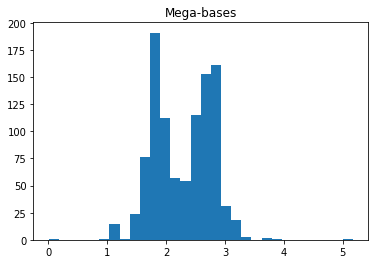

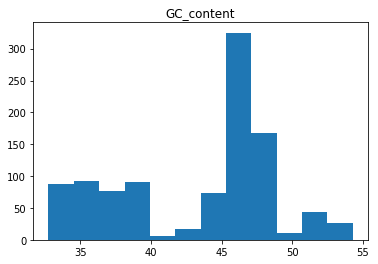

In [5]:
fasta_file_paths = glob.glob('../nt_fastas/*.faa')
fasta_genome_ids = [x.replace("../nt_fastas/","").replace(".faa","") for x in fasta_file_paths]

Mbs = []
contigs = []
sequences = []
GC_content = []
Ns_all = []
percent_n = []
complete_genomes = []

for genome_id in fasta_genome_ids:
    try:
        mb_temp = total_dataset_dict[genome_id]['Mb']
        Mbs.append(mb_temp)
        contigs.append(total_dataset_dict[genome_id]['contigs'])
        GC_content.append(total_dataset_dict[genome_id]['GC'])
        n_temp = total_dataset_dict[genome_id]['Ns']
        Ns_all.append(n_temp)
        percent_n_temp = round(n_temp/(mb_temp*1000000), 4)
        percent_n.append(percent_n_temp)
        if total_dataset_dict[genome_id]['contigs'] == 1:
            complete_genomes.append(genome_id)
            
    except:
        pass

# Read in Meta
with open('../Data/PATRIC_genome_1508_with_meta_short_1023_slim.csv','r') as csvfile:
    species_dict = {}
    line_count = 0
    for line in csvfile:
        if line_count == 0:
            line_count = 1
            continue
        if str(line.strip()).split(",")[0] in set(complete_genomes):
            species_dict[str(line.strip()).split(",")[0]] = str(line.strip()).split(",")[1]

plt.hist(Mbs, bins='auto')  #list(frange(0,1.05,0.05)), range=(0,1)
plt.title("Mega-bases")
plt.show()

plt.hist(GC_content, bins='auto')  #list(frange(0,1.05,0.05)), range=(0,1)
plt.title("GC_content")
plt.show()

In [6]:
def species_gc_plot(species_of_interest, species_dict, total_dataset_dict):
    genome_id_int = []
    for key in species_dict.keys():
        if species_dict[key] == species_of_interest:
            genome_id_int.append(key)
    GC_content = []
    for genome_id in set(genome_id_int):
        if genome_id == '1579.33' or genome_id == '29397.12' or genome_id == '1613.113' or genome_id == '47715.249':
            continue
        GC_content.append(total_dataset_dict[genome_id]['GC'])
    ref_GC = np.mean(GC_content)

    species_GC_spread = []
    with open('../Data/PATRIC_genome_1508_with_meta_short_1023_slim.csv','r') as csvfile:
        line_count = 0
        for line in csvfile:
            if line_count == 0:
                line_count = 1
                continue
            genome_id = str(line.strip()).split(",")[0]
            species_in_question = str(line.strip()).split(",")[1]
    #         print(species_in_question)
            if species_in_question == species_of_interest:
                try:
                    species_GC_spread.append(total_dataset_dict[genome_id]['GC'])
                except:
                    pass

    # print(ref_GC)
    
    
    plt.hist(GC_content, list(frange(30,55,0.5)), range=(30,55)) #
    plt.title(species_of_interest + " GC Reference Spread")
    plt.show()
    
    plt.hist(species_GC_spread, list(frange(30,55,0.5)), range=(30,55)) #
    plt.title(species_of_interest + " GC spread: Reference = " + str(ref_GC))
    plt.show()

In [7]:
# Remove outlier Acidophilus
species_of_interest = 'acidophilus'
for key in species_dict.keys():
    if species_dict[key] == species_of_interest:
        if total_dataset_dict[key]['GC'] > 50:
            print(species_of_interest + ': ' + key)
            
# Remove outlier Acidophilus
species_of_interest = 'delbrueckii'
for key in species_dict.keys():
    if species_dict[key] == species_of_interest:
        if total_dataset_dict[key]['GC'] < 46:
            print(species_of_interest + ': ' + key)

# Remove outlier Fermentum
species_of_interest = 'fermentum'
for key in species_dict.keys():
    if species_dict[key] == species_of_interest:
        if total_dataset_dict[key]['GC'] < 46:
            print(species_of_interest + ': ' + key)
            
# Remove outlier rhamnosus
species_of_interest = 'rhamnosus'
for key in species_dict.keys():
    if species_dict[key] == species_of_interest:
        if total_dataset_dict[key]['GC'] < 47:
            print(species_of_interest + ': ' + key)

acidophilus: 1579.33
delbrueckii: 29397.12
fermentum: 1613.113
rhamnosus: 47715.249


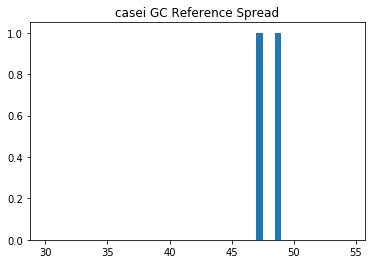

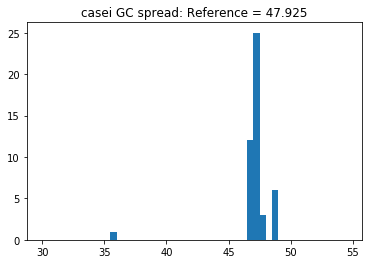

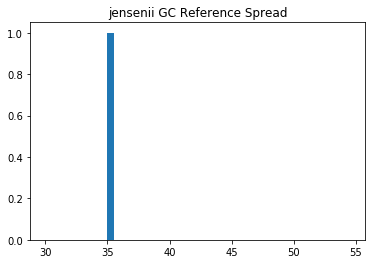

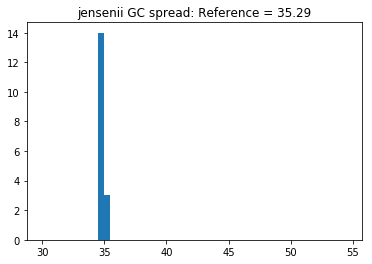

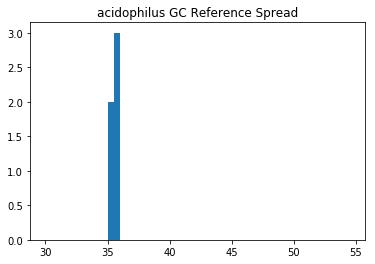

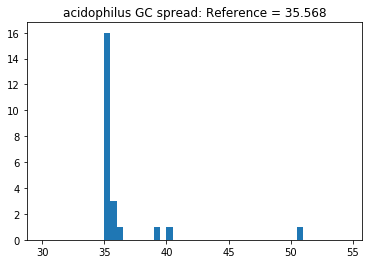

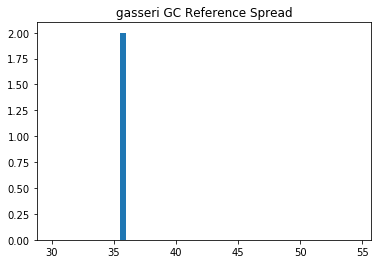

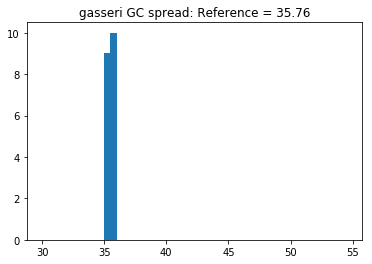

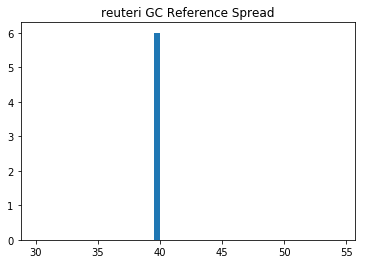

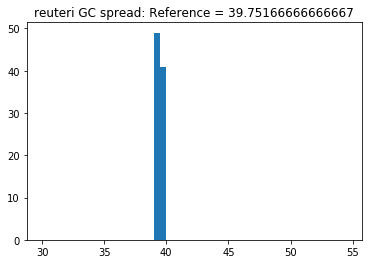

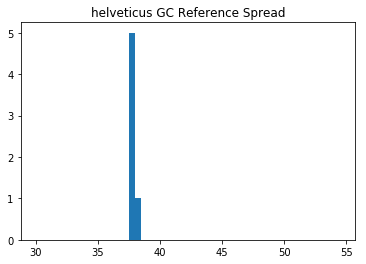

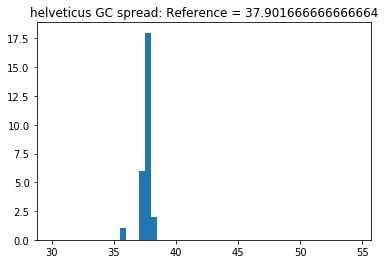

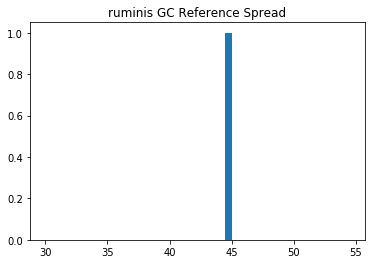

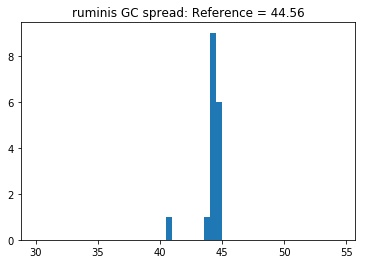

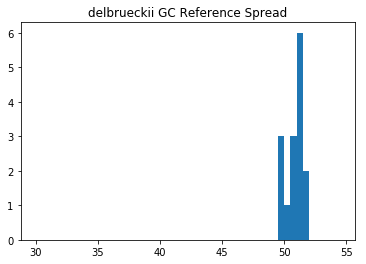

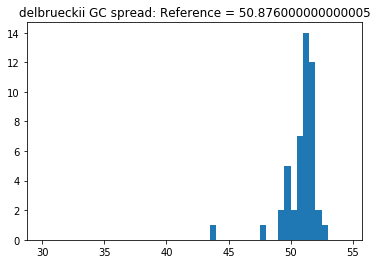

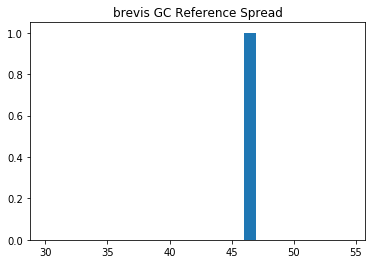

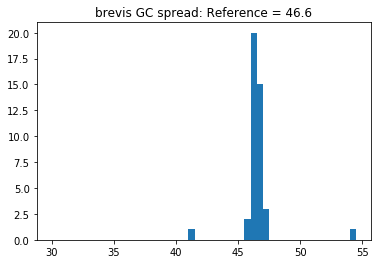

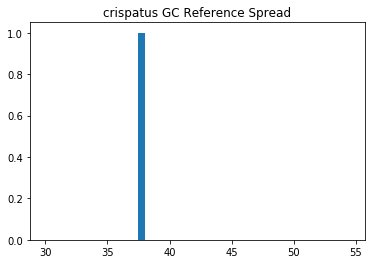

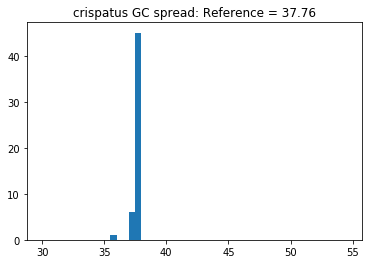

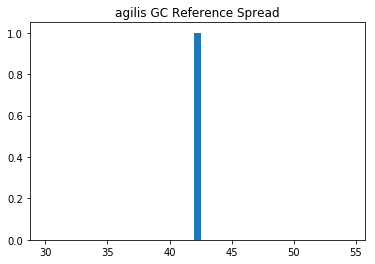

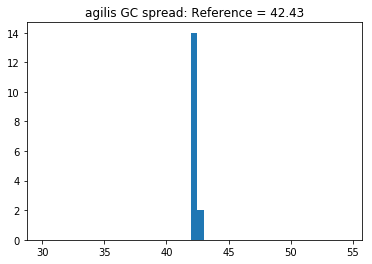

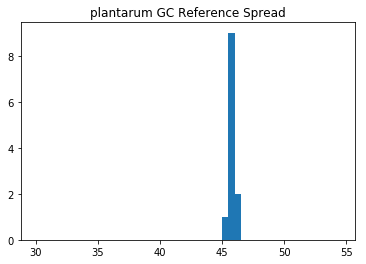

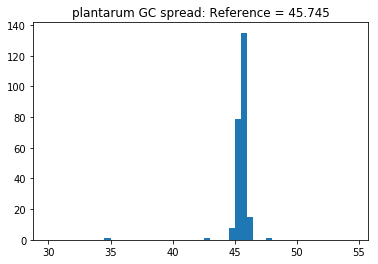

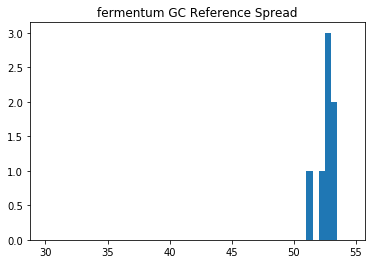

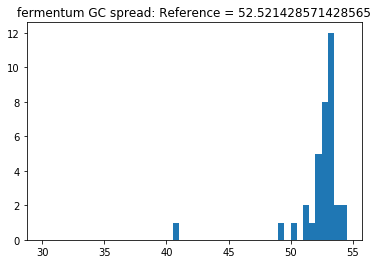

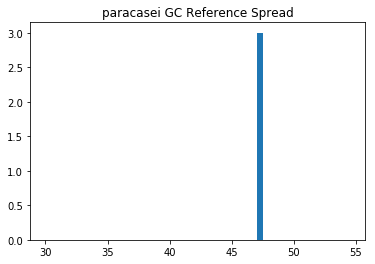

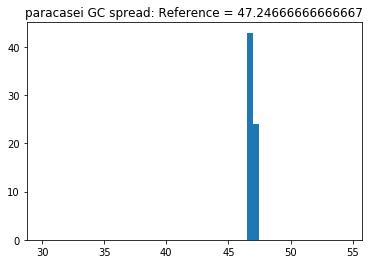

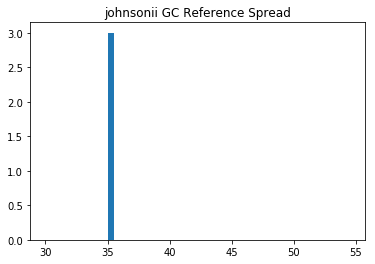

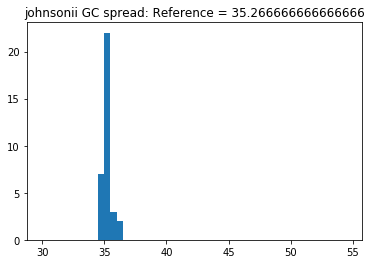

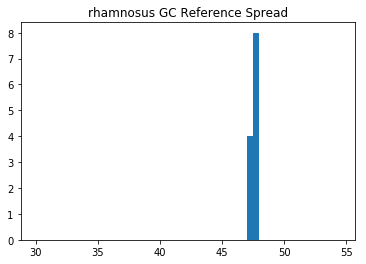

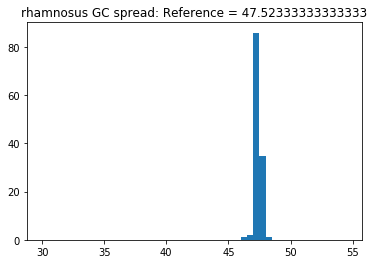

In [8]:
species_w_refs = []
for key in species_dict.keys():
    species_w_refs.append(species_dict[key])
species_w_refs = set(species_w_refs)

for species_of_interest in species_w_refs:
    species_gc_plot(species_of_interest, species_dict, total_dataset_dict)
    
# Expecting to lose 15 genomes

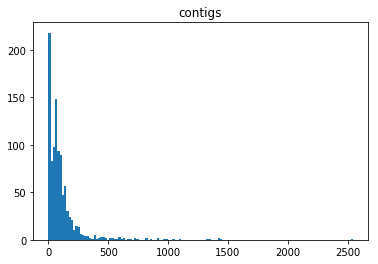

In [9]:
plt.hist(contigs, bins='auto')  #list(frange(0,1.05,0.05)), range=(0,1)
plt.title("contigs")
plt.show()

In [10]:
contigs_to_keep = []
count = 0
for n in contigs:
    if n < 301:
        contigs_to_keep.append(n)
    else:
        count = count + 1
print(len(contigs_to_keep))
print(count)

958
59


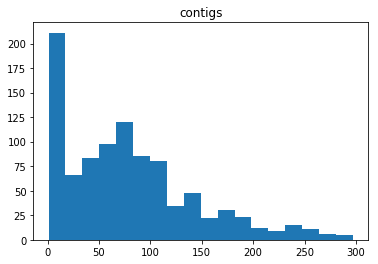

In [11]:
plt.hist(contigs_to_keep, bins='auto')  #list(frange(0,1.05,0.05)), range=(0,1)
plt.title("contigs")
plt.show()

In [12]:
percent_n_bad = []
count = 0
for n in percent_n:
    if n > .0005:
        percent_n_bad.append(n)
    else:
        count = count + 1
print(len(percent_n_bad))
print(count)

96
921


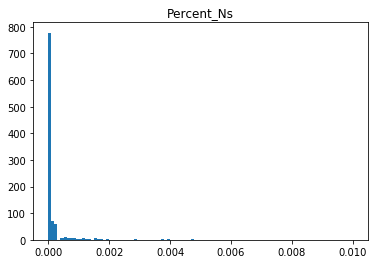

In [13]:
plt.hist(percent_n, bins=list(frange(0,.01,0.0001)), range=(0,0.01))  #list(frange(0,1.05,0.05)), range=(0,1)
plt.title("Percent_Ns")
plt.show()